In [1]:
import numpy as np
import torch
from torchvision import transforms
import apex
import csv
import data
import models
import ast
from sklearn.model_selection import train_test_split
# from tqdm.notebook import tqdm
from fastprogress.fastprogress import master_bar, progress_bar
from config import config

### Data Loading

In [2]:
def parse_list(input_str):    
    return ast.literal_eval(input_str)

reports = {}

with open(config.cleaned_reports) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
            uid, problems, findings, impression = row[1:]
            reports[str(uid)] = (parse_list(problems), findings, impression)

def create_report_splits(reports, seed=1337):
    uid_list = list(reports.keys())
    train_uids, valtest_uids = train_test_split(uid_list, test_size=0.2, random_state=seed)
    valid_uids, test_uids = train_test_split(valtest_uids, test_size=0.5, random_state=seed)
    
    train_reports = {}
    valid_reports = {}
    test_reports = {}
    splits = [train_uids, valid_uids, test_uids]
    output_reports = [train_reports, valid_reports, test_reports]
    
    for i in range(len(splits)):
        for uid in splits[i]:
            output_reports[i][str(uid)] = reports[str(uid)]
            
    return output_reports

train_reports, valid_reports, _ = create_report_splits(reports)

train_dataset = data.XRayDataset(
    reports=train_reports,
    transform=transforms.Compose([
        transforms.Resize(2048),
        transforms.CenterCrop((2048,2048)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]
))
train_dataloader = torch.utils.data.dataloader.DataLoader(train_dataset,
                                                          collate_fn=data.collate_fn,
                                                          pin_memory=True,
                                                          shuffle=True,
                                                          batch_size=config.batch_size,
                                                          num_workers=config.batch_size)

valid_dataset = data.XRayDataset(
    reports=valid_reports,
    transform=transforms.Compose([
        transforms.Resize(2048),
        transforms.CenterCrop((2048,2048)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        ]
))
valid_dataloader = torch.utils.data.dataloader.DataLoader(valid_dataset,
                                                          collate_fn=data.collate_fn,
                                                          pin_memory=True,
                                                          shuffle=True,
                                                          batch_size=config.batch_size,
                                                          num_workers=config.batch_size)

### Build Model

In [3]:
memory_format = torch.channels_last
num_classes = len(train_dataset.classes)

encoder = models.EncoderCNN(config.emb_dim, num_classes).to(config.device, memory_format=memory_format)
decoder = models.DecoderRNN(config.emb_dim, config.hidden_dim, len(train_dataset.vocab), config.num_layers).to(config.device, memory_format=memory_format)

classes_loss = torch.nn.BCEWithLogitsLoss()
outputs_loss = torch.nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = apex.optimizers.FusedAdam(params, lr=config.learning_rate)

[encoder, decoder], optimizer = apex.amp.initialize([encoder, decoder], optimizer, opt_level="O1")

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


### Train Model

In [4]:
def train_one_epoch(dataloader, batch_size, encoder, decoder, classes_loss, outputs_loss, optimizer, train=True):
    total_step = len(dataloader.dataset)//batch_size
    if train:
        encoder.train()
        decoder.train()
    else:
        encoder.eval()
        decoder.eval()
    running_c_loss = torch.Tensor([0.0])
    running_o_loss = torch.Tensor([0.0])
    state_h, state_c = decoder.zero_state(batch_size)
    state_h = state_h.to(config.device, non_blocking=True)
    state_c = state_c.to(config.device, non_blocking=True)
    with torch.set_grad_enabled(train):
        for i, (images, class_labels, captions, lengths) in enumerate(progress_bar(dataloader)):
            images = images.to(config.device, non_blocking=True).contiguous(memory_format=memory_format)
            captions = captions.to(config.device, non_blocking=True)
            class_labels = class_labels.to(config.device, non_blocking=True)
            targets = torch.nn.utils.rnn.pack_padded_sequence(captions, lengths, batch_first=True, enforce_sorted=False)[0]
            encoder.zero_grad()
            decoder.zero_grad()
            logits, features = encoder(images)
            c_loss = classes_loss(logits, class_labels)
            outputs, (state_h, state_c) = decoder(features, captions, lengths, (state_h, state_c))
            o_loss = outputs_loss(outputs, targets)
            if train:
                with apex.amp.scale_loss(c_loss, optimizer) as scaled_loss:
                    scaled_loss.backward(retain_graph=True)
                with apex.amp.scale_loss(o_loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                state_h = state_h.detach()
                state_c = state_c.detach()
                optimizer.step()
            running_c_loss += c_loss
            running_o_loss += o_loss
    c_loss = float(running_c_loss.item()/total_step)
    o_loss = float(running_o_loss.item()/total_step)
    return c_loss, o_loss

In [ ]:
num_epochs = 2

print("Start training")

for epoch in range(num_epochs):
    print("\nEpoch", epoch+1, "/", num_epochs, ":\n")
    
    train_c_loss, train_o_loss = train_one_epoch(train_dataloader, config.batch_size, encoder, decoder, classes_loss, outputs_loss, optimizer, train=True)
    valid_c_loss, valid_o_loss = train_one_epoch(valid_dataloader, config.batch_size, encoder, decoder, classes_loss, outputs_loss, optimizer, train=False)

    print("train_loss - ", round(train_c_loss,3),round(train_o_loss,3), "- perplexity -", round(np.exp(train_o_loss),3), 
          "- valid_loss - ", round(valid_c_loss,3),round(valid_o_loss,3), "- perplexity -", round(np.exp(valid_o_loss),3))

Start training

Epoch 1 / 2 :



In [5]:
# torch.save(encoder.state_dict(), 'encoder.pt')
# torch.save(decoder.state_dict(), 'decoder.pt')
encoder.load_state_dict(torch.load('encoder.pt'))
decoder.load_state_dict(torch.load('decoder.pt'))

### Inference

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

encoder.eval()
decoder.eval()

DecoderRNN(
  (embed): Embedding(52, 128)
  (lstm): LSTM(128, 128, num_layers=3, batch_first=True)
  (linear): Linear(in_features=128, out_features=52, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


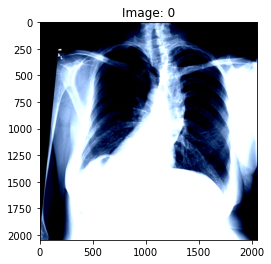

 Original: no acute changes from prior imaging.
Generated: cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


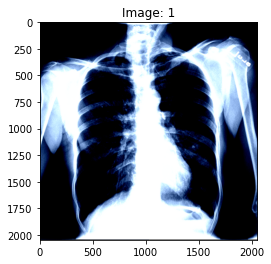

 Original: 1. no acute cardiopulmonary abnormality. 2. no suspicious masses or nodules.
Generated: cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


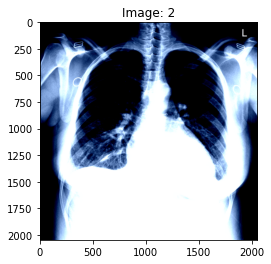

 Original: borderline cardiac enlargement. vascular congestion without overt pulmonary edema. basilar atelectasis with xxxx posterior recess pleural effusions. overall, findings of mild volume overload.
Generated: cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


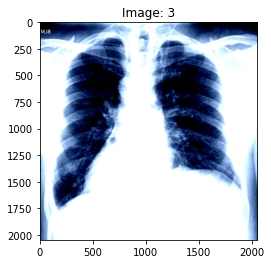

 Original: xxxx xxxx right pleural effusion.
Generated: cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


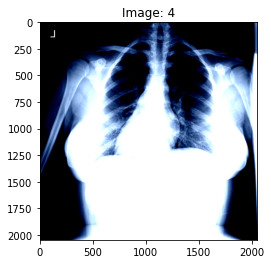

 Original: no acute cardiopulmonary abnormality identified.
Generated: cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


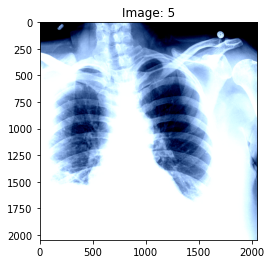

 Original: minimal atelectasis right base. no evidence of tuberculosis. heart size is normal.
Generated: cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


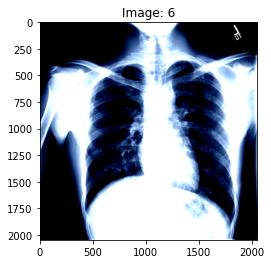

 Original: no acute cardiopulmonary disease.
Generated: cccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


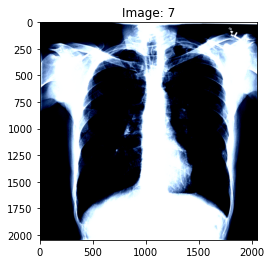

 Original: appearance suggests emphysema. apical capping, slightly greater at the left. recommend comparison with prior films or followup chest x-xxxx films to confirm stability and approximately 4 months in xxxx. critical result notification documented through primordial.
Generated: bccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc



KeyboardInterrupt: 

In [5]:
for index in range(0, 10):
    image, _, impression = train_dataset.__getitem__(index)
    image_tensor = image.unsqueeze(0).to(config.device)
    logits, feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = list(sampled_ids[0].cpu().numpy())

    plt.title("Image: "+str(index))
    plt_img = np.moveaxis(image.numpy(), 0, -1)
    plt.imshow(plt_img)
    plt.show()

    print(" Original:", train_dataset.tokenizer.decode(impression))
    print("Generated:", train_dataset.tokenizer.decode(sampled_ids))
    print("")